## Task VI A
 Train a Masked Autoencoder (MAE) on the no_sub samples from the provided dataset to learn a feature representation of strong lensing images. The MAE should be trained for reconstructing masked portions of input images.

- Dataset Description: The Dataset consists of three classes: no_sub (no substructure), cdm (cold dark matter substructure), and axion (axion-like particle substructure).

- Evaluation Metrics: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

# Leveraging a Simple CNN-Based MAE

In this we chose a simpler version of the Masked Autoencoder (MAE) using convolutional neural networks (CNNs) instead of Vision Transformers. This decision was primarily influenced by two factors:

1. **Compute Constraints**  
   Modern MAE architectures built with Vision Transformers require significant computational resources due to their complex attention mechanisms and larger parameter counts. By employing a CNN-based encoder, we reduced the computational burden, allowing for faster iterations and more accessible experimentation under limited compute environments.

2. **Demonstrating the Power of ESRGAN**  
   The primary objective is to use the encoder learnt in this pre-training task for other downstream finetuning tasks like classification and super-resolution. So to showcase the super resolution capabilities of the Enhanced Super Resolution Generative Adversarial Network (ESRGAN) and for VIT encoder to not be an issue for training ESRGAN, we go forward with a simple CNN based MAE.


In [ ]:
# import os
# import gdown
# import zipfile

# # Define the Google Drive file ID and output filename
# file_id = "1znqUeFzYz-DeAE3dYXD17qoMPK82Whji"
# output_file = "dataset.zip"

# # Download the file using gdown
# gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output_file, quiet=False)

# # Create a directory for extraction
# extract_dir = "dataset"
# os.makedirs(extract_dir, exist_ok=True)

# # Unzip the file
# try:
#     with zipfile.ZipFile(output_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print("Extraction successful!")
# except zipfile.BadZipFile:
#     print("Error: The downloaded file is not a valid ZIP file.")

# # List extracted files
# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)


In [ ]:
# !pip install einops


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from einops import rearrange


In [4]:
sample_file = "dataset/Dataset/no_sub/no_sub_sim_289486245275525753529636609454217463791.npy"

# Load file
data = np.load(sample_file, allow_pickle=True)

# Print shape and contents
print(f"File: {sample_file}")
print(f"Data Shape: {data.shape}")
print(f"Data Type: {type(data)}")


File: dataset/Dataset/no_sub/no_sub_sim_289486245275525753529636609454217463791.npy
Data Shape: (64, 64)
Data Type: <class 'numpy.ndarray'>


In [5]:
import numpy as np

sample_file = "dataset/Dataset/no_sub/no_sub_sim_289486245275525753529636609454217463791.npy"

# Load data
data = np.load(sample_file, allow_pickle=True)

# Print structure
print("Type of data:", type(data))
print("Data shape:", data.shape)
print("First element type:", type(data[0]) if isinstance(data, (list, np.ndarray)) else "N/A")

# If the first element is another array or list, print its shape
if isinstance(data[0], (np.ndarray, list)):
    print("First element shape:", np.array(data[0]).shape)


Type of data: <class 'numpy.ndarray'>
Data shape: (64, 64)
First element type: <class 'numpy.ndarray'>
First element shape: (64,)


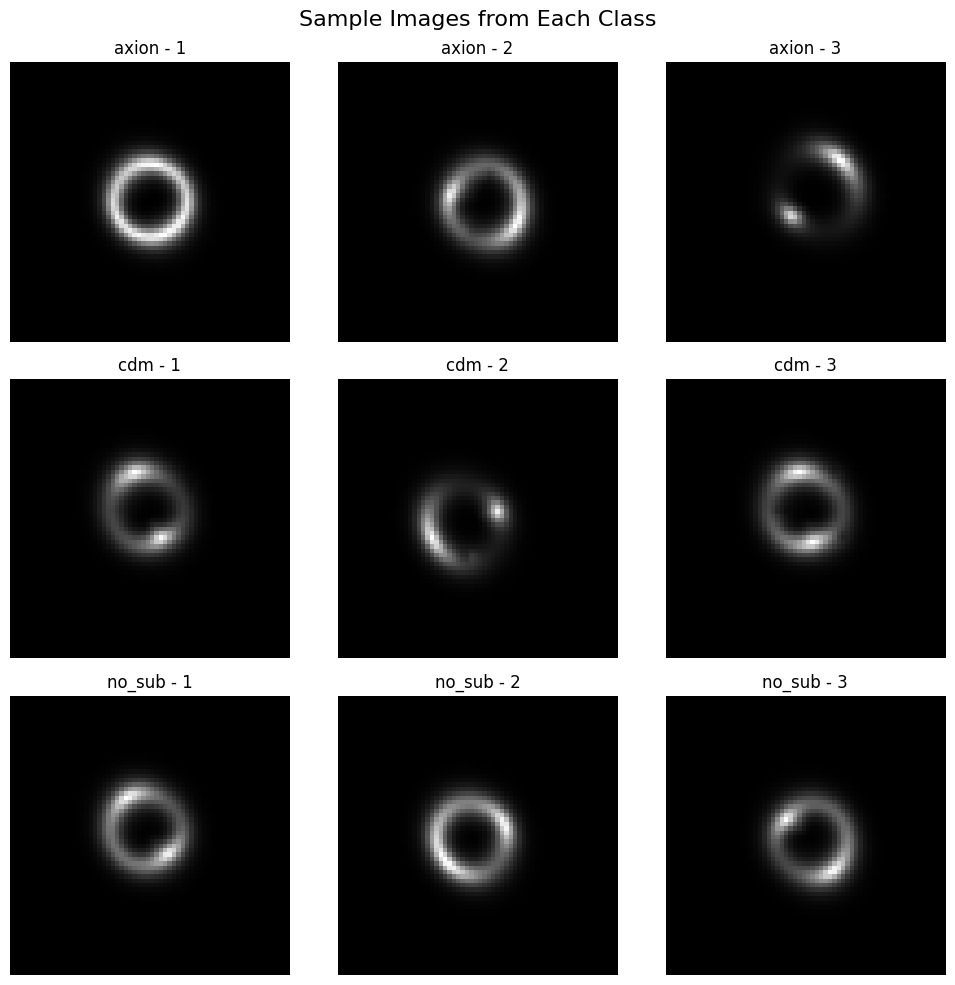

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define dataset directories
dataset_dirs = {
    "axion": "dataset/Dataset/axion",
    "cdm": "dataset/Dataset/cdm",
    "no_sub": "dataset/Dataset/no_sub"
}

# Number of images to visualize per class
num_images = 3

# Create a figure for visualization
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Each Class", fontsize=16)

# Iterate over dataset directories
for row_idx, (class_name, dir_path) in enumerate(dataset_dirs.items()):
    try:
        files = [f for f in os.listdir(dir_path) if f.endswith('.npy')][:num_images]
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
        continue

    for col_idx, file in enumerate(files):
        # Load file
        img_data = np.load(os.path.join(dir_path, file), allow_pickle=True)

        # Check if data is an array or contains nested sequences
        if isinstance(img_data, np.ndarray) and img_data.dtype == object:
            # Try to extract an array from the first element
            if isinstance(img_data[0], (np.ndarray, list)):
                img = np.array(img_data[0])  # Extract first valid array
            else:
                print(f"Skipping {file}: Unable to convert object array.")
                continue
        elif isinstance(img_data, np.ndarray):
            img = img_data
        else:
            print(f"Skipping {file}: Unsupported format {type(img_data)}")
            continue

        # Ensure image is 2D for visualization
        if img.ndim > 2:
            img = img[:, :, 0]  # Take the first channel if needed

        # Display the image
        ax = axes[row_idx, col_idx]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{class_name} - {col_idx+1}")
        ax.axis("off")

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
# Custom dataset class
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = np.load(img_path, allow_pickle=True)
        img = np.array(img, dtype=np.float32)  # Convert to float32
        if img.ndim > 2:
            img = img[:, :, 0]  # Ensure it's grayscale
        if self.transform:
            img = self.transform(img)
        return img

In [9]:
# Data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the "no_sub" dataset for MAE pretraining
no_sub_dataset = LensDataset(dataset_dirs["no_sub"], transform=data_transform)
no_sub_loader = DataLoader(no_sub_dataset, batch_size=32, shuffle=True)


In [4]:

# Define Masked Autoencoder
class MaskedAutoencoder(nn.Module):
    def __init__(self, img_size=64, hidden_dim=256, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.mask_ratio = mask_ratio
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        mask = (torch.rand_like(x) > self.mask_ratio).float()
        masked_x = x * mask
        encoded = self.encoder(masked_x)
        reconstructed = self.decoder(encoded)
        return reconstructed, mask

In [10]:

# Train MAE
mae = MaskedAutoencoder().to(device)
optimizer = optim.Adam(mae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [11]:
def train_mae(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images in dataloader:
            images = images.to(device)  # Move data to GPU
            optimizer.zero_grad()
            reconstructed, mask = model(images)
            loss = criterion(reconstructed * mask, images * mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

train_mae(mae, no_sub_loader, epochs=10)

Epoch 1/10, Loss: 0.2742
Epoch 2/10, Loss: 0.2732
Epoch 3/10, Loss: 0.2731
Epoch 4/10, Loss: 0.2731
Epoch 5/10, Loss: 0.2731
Epoch 6/10, Loss: 0.2732
Epoch 7/10, Loss: 0.2731
Epoch 8/10, Loss: 0.2732
Epoch 9/10, Loss: 0.2730
Epoch 10/10, Loss: 0.2729


In [23]:
# Save the MAE model
mae_save_path = "mae_pretrained.pth"
torch.save(mae.state_dict(), mae_save_path)

print(f"Pretrained MAE model saved at {mae_save_path}")


Pretrained MAE model saved at mae_pretrained.pth
